### Dataset description

This dataset features ratings data of 400 movies from 1097 research participants. 

* 1st row: Headers (Movie titles/questions) – note that the indexing in this list is from 1
* Row 2-1098: Responses from individual participants
* Columns 1-400: These columns contain the ratings for the 400 movies (0 to 4, and missing)
* Columns 401-421: These columns contain self-assessments on sensation seeking behaviors (1-5)
* Columns 422-464: These columns contain responses to personality questions (1-5)
* Columns 465-474: These columns contain self-reported movie experience ratings (1-5)
* Column 475: Gender identity (1 = female, 2 = male, 3 = self-described)
* Column 476: Only child (1 = yes, 0 = no, -1 = no response)
* Column 477: Movies are best enjoyed alone (1 = yes, 0 = no, -1 = no response)

## Part 1 - Hypothesis Testing of movie ratings data

#### (For all the tests conducted, level of significance (α) is set to 0.005)

In [38]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.decomposition import PCA
import seaborn as sns
import itertools
from sklearn import decomposition

In [2]:
numMovies = 400
numParticipants = 1097

#Load the data from the csv file
# We want just the data, so skip the first row / header
data = np.genfromtxt('movieReplicationSet.csv', delimiter = ',', skip_header = 1)

#Pandas df of the data
df = pd.read_csv ('movieReplicationSet.csv')

In [4]:
df0 = df.iloc[0:numParticipants,0:numMovies] #df containing only movie names and ratings
columns = list(df.columns)

#replace nans with 0
#df0 = df0.fillna(0)

#average rating for each movie
avg_rating = df0.mean(axis=0)
df0.loc[len(df0)] = avg_rating

### 1) Are movies that are more popular (operationalized as having more ratings) rated higher than movies that are less popular? 
#### Null Hypothesis - No they are not more popular. Calculate p-value. Compare with alpha. Reject/Keep the hypothesis

In [13]:
#Extract subset of the data. This variale is a numpy array of only the movie ratings. Size is 1097x400. 
#This also contains the nan ratings
movie_ratings = data[1:numParticipants+1 ,0:numMovies]

#Replace nan ratings with 0
#nonNAN_movie_ratings = np.nan_to_num(movie_ratings)

#Element-wise removal of nans
nonNAN_movie_ratings = movie_ratings[~np.isnan(movie_ratings)] 
number_of_ratings  = np.count_nonzero(~np.isnan(movie_ratings), axis=0)

average_rating = (np.sum(nonNAN_movie_ratings, axis=0)) / number_of_ratings

#Median-split of popularity (movies with more ratings vs less ratings)
median_num_of_ratings = np.median(number_of_ratings)
low_popularity_movies = number_of_ratings[number_of_ratings <= median_num_of_ratings]
high_popularity_movies = number_of_ratings[number_of_ratings > median_num_of_ratings]

#Run the Mann Whitney U-test
u1,p1_mw_utest = stats.mannwhitneyu(low_popularity_movies ,high_popularity_movies, alternative='less')

print('Question 1 -',p1_mw_utest)

Question 1 - 2.4067075003178358e-67


### 2) Are movies that are newer rated differently than movies that are older?
#### Null Hypothesis - Newer and older movies are rated similarly

In [14]:
year_of_movie = []
for movie in df.iloc[:, : 400].columns:
    year_of_movie.append(int(movie.split('(')[-1].split(')')[0]))
    
#Median-split movies according to year
median_year = np.median(year_of_movie)

old_movies, new_movies = [], []

for movie in df.iloc[:, : 400].columns:
    if int(movie.split('(')[-1].split(')')[0])\
    <= median_year: old_movies.append(df[movie].median())
    else: new_movies.append(df[movie].median())
        
u2, p2 = stats.mannwhitneyu(old_movies, new_movies, alternative='two-sided')
print('Question 2 -',p2)

Question 2 - 0.19865156776112602


### 3) Is enjoyment of ‘Shrek (2001)’ gendered, i.e. do male and female viewers rate it differently?
#### Null Hypothesis - Male and female viewers do not rate Shrek differently

In [16]:
#Clean the data - Remove any missing values of gender, non-binary
df3 = df[df['Gender identity (1 = female; 2 = male; 3 = self-described)'].notna()]

#Split into male and female
female = df3[df3['Gender identity (1 = female; 2 = male; 3 = self-described)']==1] 
female_shrek = female[['Shrek (2001)']].dropna()
male = df3[df3['Gender identity (1 = female; 2 = male; 3 = self-described)']==2] 
male_shrek = male[['Shrek (2001)']].dropna()

mean_female_ratings = female_shrek.mean()
mean_male_ratings = male_shrek.mean()

#shrek_male = mean_male_ratings["Shrek (2001)"]
#shrek_female = mean_female_ratings["Shrek (2001)"]

#Run t-test
#t3,p3 = stats.ttest_ind(male ,female)
u3,p3 = stats.mannwhitneyu(male_shrek ,female_shrek)
print("Question 3-" , p3)

Question 3- [0.05053663]


### 4) What proportion of movies are rated differently by male and female viewers?
#### Null Hypothesis - Male and Female viewers rate movies similarly 

In [20]:
#Clean the data - Remove any missing values of gender, non-binary - Use df3

#Split dataset into male and female  - #Done in previous question male, female
#Get correspoppnding ratings for each movie

#Run the test for every movie and count for how many movies, males and females rate them differently
count = 0
for i in range(0,numMovies):
    m_rating = male.iloc[:,i].dropna()
    f_rating = female.iloc[:,i].dropna()
    u,p = stats.mannwhitneyu(m_rating ,f_rating)
    #t,p = stats.ttest_ind(m_rating ,f_rating)
    if(p<0.005):
        count+=1
        
print('Number of movies where male and females rate differently =',count)
print("Proportion = ",(count/numMovies)*100, '%')

Movies where male and females rate differently = 50
Proportion =  12.5 %


### 5) Do people who are only children enjoy ‘The Lion King (1994)’ more than people with siblings?
#### Null Hypothesis - No such difference

In [21]:
#Remove missing data (-1 i.e. did not respond)
df5 = df[df['Are you an only child? (1: Yes; 0: No; -1: Did not respond)'] != -1]

#Split data into only child and people with siblings
onlychild = df3[df3['Are you an only child? (1: Yes; 0: No; -1: Did not respond)']==1] 
onlychild_lionking = onlychild[['The Lion King (1994)']].dropna()
sibling = df3[df3['Are you an only child? (1: Yes; 0: No; -1: Did not respond)']==0] 
sibling_lionking = sibling[['The Lion King (1994)']].dropna()

#Run the test
u5,p5 = stats.mannwhitneyu(onlychild_lionking ,sibling_lionking, alternative='greater')
print("Question 5-",p5)

Question 5- [0.97701498]


### 6) What proportion of movies exhibit an “only child effect”, i.e. are rated different by viewers with siblings vs. those without?

In [24]:
#Split dataset into only child and people with siblings - Done in previous question
#Get corresponding ratings for each category of people  

#Run the test for every movie and count for how many movies, only children and people with siblings rate them differently
count = 0
for i in range(0,numMovies):
    oc_rating = onlychild.iloc[:,i].dropna()
    s_rating = sibling.iloc[:,i].dropna()
    u,p = stats.mannwhitneyu(oc_rating ,s_rating)
    #t,p = stats.ttest_ind(oc_rating ,s_rating)
    if(p<0.005):
        count+=1
        
print('Number of movies where only child and siblings rate differently =',count)
print("Proportion = ",round((count/numMovies)*100,2), '%')

#Movies where only child and siblings rate differently = 7
Proportion =  1.75 %


### 7) Do people who like to watch movies socially enjoy ‘The Wolf of Wall Street (2013)’ more than those who prefer to watch them alone?

#### Null hypothesis - People who watch movies socially do not enjoy ‘The Wolf of Wall Street’ more than those who prefer to watch them alone

In [25]:
df7 = df[df['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] != -1]

#Split dataset into people who watch movies alone vs socially 
#Get corresponding ratings for each category of people
alone = df7[df7['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)']==1] 
alone_wolf = alone[['The Wolf of Wall Street (2013)']].dropna()
social = df7[df7['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)']==0] 
social_wolf = social[['The Wolf of Wall Street (2013)']].dropna()

#Run the test for ratings of Wold of Wall Street 
u7,p7 = stats.mannwhitneyu(social_wolf, alone_wolf, alternative='greater')
print("Question 7-",p7)

Question 7- [0.9436658]


### 8) What proportion of movies exhibit such a “social watching” effect?
#### Null hypothesis - People who watch movies socially do not enjoy a particular movie more than those who prefer to watch them alone

In [27]:
#Split dataset into people who watch movies alone vs socially - Done in previous question 
#Get corresponding ratings for each category of people


#Run the test for all movies and count for how many movies, "social watching" effect is observed
count = 0
for i in range(0,numMovies):
    alone_rating = alone.iloc[:,i].dropna()
    social_rating = social.iloc[:,i].dropna()
    u,p = stats.mannwhitneyu(social_rating ,alone_rating)
    if(p<0.005):
        count+=1
        
print('Number of movies which exhibit social watching effect',count)
print("Proportion = ",round((count/numMovies)*100,2), '%')

Number of movies which exhibit social watching effect 10
Proportion =  2.5 %


### 9)Is the ratings distribution of ‘Home Alone (1990)’ different than that of ‘Finding Nemo (2003)’? 
#### Null hypothesis -The ratings distribution of ‘Home Alone’ is not different from that of ‘Finding Nemo’

Question 9- 3.2626485864491195e-10


Text(0.5, 1.0, 'Finding Nemo (2003)')

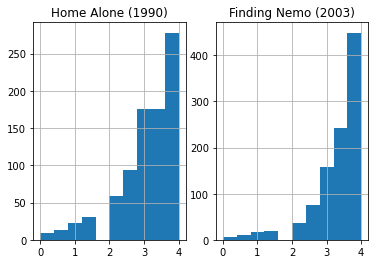

In [32]:
subset = df[['Home Alone (1990)', 'Finding Nemo (2003)']]
s = subset.dropna(axis=0,how='any')
homealone = subset['Home Alone (1990)']
findingnemo = subset['Finding Nemo (2003)']



#Run the Kolmogorov-Smirnov (KS) test for these 2 movies
ks, p = stats.ks_2samp(homealone, findingnemo) 

print("Question 9-",p)

fig, axes = plt.subplots(1, 2)

homealone.hist(ax=axes[0])
axes[0].set_title('Home Alone (1990)')
findingnemo.hist(ax=axes[1])
axes[1].set_title('Finding Nemo (2003)')

### 10) There are ratings on movies from several franchises ([‘Star Wars’, ‘Harry Potter’, ‘The Matrix’, ‘Indiana Jones’, ‘Jurassic Park’, ‘Pirates of the Caribbean’, ‘Toy Story’, ‘Batman’]) in this dataset. How many of these are of inconsistent quality, as experienced by viewers?
#### Null hypothesis - Movies in a particular franchise are not of inconsistent quality

In [35]:
#Extract data for all movies for each franchise
franchises = ["Star Wars", "Harry Potter", "The Matrix", "Indiana Jones", "Jurassic Park", "Pirates of the Caribbean", "Toy Story", "Batman"]

#Only Harry Potter and Pirates of the Caribbean are of consistent quality

#Run the (Dependent groups t-test because same people rated all movies) test for each franchise 
#You can also use Kruskal Wallis group test

for x in franchises:
    franchise = df.filter(regex=x)
    franchise = franchise.dropna(axis=0,how='any')
    list_of_movies_in_franchise = list()
    for (columnName, columnData) in franchise.iteritems():
        list_of_movies_in_franchise.append(columnData.dropna().values)
    h, p = stats.kruskal(*list_of_movies_in_franchise)
    print(x,p)

Star Wars 6.940162236984522e-40
Harry Potter 0.11790622831256074
The Matrix 1.7537323830838066e-09
Indiana Jones 1.020118354785894e-11
Jurassic Park 1.8492328391686058e-11
Pirates of the Caribbean 0.035792727694248905
Toy Story 7.902234665149812e-06
Batman 4.1380499020034183e-19


### 11) Is the rating distribution for the movie ‘Inception (2010)’ different for people who have trouble following the story of a movie and those who do not?
#### Null Hypothesis - The ratings distribution for the movie Inception (2010), is not different for the people who have trouble following the story of a movie and those who don’t. 


In [100]:
#Subset of df where we have only answer to the question and ratings for Inception
dfec2 = df[['I have trouble following the story of a movie', 'Inception (2010)']]

#only include those users who have answered the question and have given rating to the movie
#Basically row-wise removal of nans
dfec2 = dfec2.dropna(axis=0,how='any')

#median split- have trouble(4,5) and do not have trouble(1,2,3)
trouble_yes = dfec2[dfec2['I have trouble following the story of a movie']>3] 
trouble_no = dfec2[dfec2['I have trouble following the story of a movie']<=3] 

troubled_1 = dfec2[dfec2['I have trouble following the story of a movie'] == 1]
troubled_2 = dfec2[dfec2['I have trouble following the story of a movie'] == 2]
troubled_3 = dfec2[dfec2['I have trouble following the story of a movie'] == 3]
troubled_4 = dfec2[dfec2['I have trouble following the story of a movie'] == 4]
troubled_5 = dfec2[dfec2['I have trouble following the story of a movie'] == 5]

#NH - no relation between lliking wolf of wall st and gambling
#people who have gambled and have not gambled like the movie similarly
#Run the Kolmogorov-Smirnov (KS) test for these 2 movies - similarity of dist. 

#people who have trouble and do not have trouble give similar ratings to inception
ks2, p2 = stats.ks_2samp(trouble_yes['Inception (2010)'], trouble_no['Inception (2010)']) 
'''
list_of_movies_in_franchise = list()
for (columnName, columnData) in franchise.iteritems():  
    list_of_movies_in_franchise.append(columnData.dropna().values)
h, p = stats.kruskal(*list_of_movies_in_franchise)
'''    
h, p = stats.kruskal(troubled_1['Inception (2010)'], troubled_2['Inception (2010)'], troubled_3['Inception (2010)'], troubled_4['Inception (2010)'], troubled_5['Inception (2010)'])
u,up = stats.mannwhitneyu(trouble_yes['Inception (2010)'], trouble_no['Inception (2010)'])

print("KS - Yes/No - ",p2)
print("Kruskal - 1,2,3,4,5 -", p)
print('Mann Whitney U test', up)

KS - Yes/No -  0.4052365829580882
Kruskal - 1,2,3,4,5 - 0.043584434093970274
Mann Whitney U test 0.06601757744031499


## Part 2 - Correlation and Regression of Movie Ratings Data

**Note:** For all missing values in the data, we use the average of the corresponding column to fill in the missing data. 

In this problem, under **the most correlated**, we consider the largest correlation in the absolute value.

In [40]:
#%% For all missing values in the data, use the average of the corresponding column so to fill in the missing data.
from sklearn.impute import SimpleImputer

imputed_df = df

for i in range(477):
    X = df.iloc[:,i].values.reshape(-1,1)
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer = imputer.fit(X)  
    X = imputer.transform(X)
    imputed_df.iloc[:,i] = X
    

In [41]:
#Calculate absolute value of correlation for each pair of users. 
df_rate = imputed_df.iloc[:,0:400] #ratings of all movies by all the users(1097) [columns 1-400]
df_pers = imputed_df.iloc[:, 400:474] #personality questions of all users over columns 401-474

df_rate = df_rate.to_numpy()
df_pers = df_pers.to_numpy()

#We compute the correlation matrix where diagonal elements are self-correlation values.
correlation = pd.DataFrame(df_rate.transpose()).corr().abs()
#Replace values of self-correlation with -1
new = correlation.replace(to_replace= 1, value =-1)

### 1.1) To find the most correlated user, for every user in the given data. 

In [43]:
#Most correlated user for each user.  
max_correlation_each_user = new.max()
most_correlated_user_idx = new.idxmax() #1.1
print(most_correlated_user_idx)

0       118
1       831
2       896
3        19
4       784
       ... 
1092    896
1093    784
1094    896
1095    896
1096    710
Length: 1097, dtype: int64


### 1.2) What is the pair of the most correlated users in the data? 

In [44]:
#Pair of most correlated users
most_correlated_pair = np.array([2,0]) #1.2 
most_correlated_pair[0] = max_correlation_each_user.idxmax()
most_correlated_pair[1] = most_correlated_user_idx[max_correlation_each_user.idxmax()]
print('Most correlated users are', most_correlated_pair[0], 'and', most_correlated_pair[1])

Most correlated users are 831 and 896


### 1.3) What is the value of this highest correlation?

In [45]:
#Value of highest correlation
highest_correlation = max_correlation_each_user.max()
print('Highest correlation is equal to', highest_correlation)

Highest correlation is equal to 0.9987890924779799


### 1,4) For users 0, 1, 2, \dots, 9, find their most correlated users. 

In [46]:
#Most correlated users for users 0,1,...9
most_corr_user0_9_idx = most_correlated_user_idx[0:10]
print('User Most Correlated User')
print(most_corr_user0_9_idx)

User Most Correlated User
0     118
1     831
2     896
3      19
4     784
5     990
6    1071
7    1074
8     821
9    1004
dtype: int64


### 2) We want to find a model between the ratings and the personal part of the data. 

For this, consider:

**Part 1**: the ratings of all users over columns 1-400: 

-- Columns 1-400: These columns contain the ratings for the 400 movies (0 to 4, and missing);

we call this part `df_rate`


**Part 2**:  the part of the data which includes all users over columns 401-474

-- Columns 401-421: These columns contain self-assessments on sensation seeking behaviors (1-5)

-- Columns 422-464: These columns contain responses to personality questions (1-5)

-- Columns 465-474: These columns contain self-reported movie experience ratings (1-5)

we call this part `df_pers`.

---

Our main task is to model: 


`df_pers = function(df_rate)`


---

**Note:** We split the original data into training and testing in the ratio 0.80: 0.20. 


In [47]:
#X - df_rate and Y - df_pers
#Splitting the original data into training and testing sets with ratio 80:20 respectively
X_train, X_test, y_train, y_test = train_test_split(df_rate, df_pers, test_size=0.2, random_state=42) 

### 2.1) Model `df_pers = function(df_rate)` by using the linear regression. 


In [48]:
# Create linear regression object
regr = linear_model.LinearRegression()

pers_questions = 74

regr.fit(X_train, y_train)
pred_train = regr.predict(X_train)  
pred_test = regr.predict(X_test)  

mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)

print('Training Error \t\t Testing Error')
print(mse_train,'\t', mse_test)

Training Error 		 Testing Error
0.6127612374234509 	 3.2509647714850916


### 2.2) Model `df_pers = function(df_rate)` by using the ridge regression with hyperparamter values alpha from [0.0, 1e-8, 1e-5, 0.1, 1, 10]. 

In [49]:
#Ridge Regression

alphas = [0.0, 1e-8, 1e-5, 0.1, 1, 10]
print('Alpha \t\t Training Error \t\t Testing Error')
for a in alphas:
    ridge = linear_model.Ridge(alpha = a)
    ridge.fit(X_train, y_train)
    pred_train = ridge.predict(X_train)  
    pred_test = ridge.predict(X_test)  
    ridge_mse_train = mean_squared_error(y_train, pred_train)
    ridge_mse_test = mean_squared_error(y_test, pred_test)
    print(a, '\t\t', ridge_mse_train, '\t\t', ridge_mse_test)

Alpha 		 Training Error 		 Testing Error
0.0 		 0.6127612374234509 		 3.250964771485118
1e-08 		 0.612761237423451 		 3.2509647623208537
1e-05 		 0.6127612374246642 		 3.250955607294804
0.1 		 0.6128675474638946 		 3.1661276597976737
1 		 0.6176596189954007 		 2.718440736635615
10 		 0.6681063711453811 		 1.8932122756432532


### 2.3) Model `df_pers = function(df_rate)` by using the lasso regression with hyperparamter values alpha from [1e-3, 1e-2, 1e-1, 1]. 


In [50]:
#Lasso Regression

alphas = [1e-3, 1e-2, 1e-1, 1]
print('Alpha \t\t Training Error \t\t Testing Error')
for a in alphas:
    lasso = linear_model.Lasso(alpha = a)
    lasso.fit(X_train, y_train)
    pred_train = lasso.predict(X_train)  
    pred_test = lasso.predict(X_test)  
    lasso_mse_train = mean_squared_error(y_train, pred_train)
    lasso_mse_test = mean_squared_error(y_test, pred_test)
    print(a, '\t\t', lasso_mse_train, '\t\t', lasso_mse_test)

Alpha 		 Training Error 		 Testing Error
0.001 		 0.6359078007727819 		 2.2804960457572663
0.01 		 0.8932351906143892 		 1.3742334226815167
0.1 		 1.210230986955849 		 1.2534246581541626
1 		 1.2261539571148226 		 1.2646356285936624


## Part 3) Applying machine learning methods to movie ratings data

In [51]:
full_data = pd.read_csv("movieReplicationSet.csv")
full_data = full_data.fillna(full_data.mean())

data = full_data.iloc[:,420:474]

data

,Is talkative,Tends to find fault with others,Does a thorough job,Is depressed/Blue,Is original/comes up with new ideas,Is reserved,Is helpful and unselfish with others,Can be somewhat careless,Is relaxed/handles stress well,Is curious about many different things,...,I have cried during a movie,I have trouble following the story of a movie,I have trouble remembering the story of a movie a couple of days after seeing it,When watching a movie I cheer or shout or talk or curse at the screen,When watching a movie I feel like the things on the screen are happening to me,As a movie unfolds I start to have problems keeping track of events that happened earlier,"The emotions on the screen ""rub off"" on me - for instance if something sad is happening I get sad or if something frightening is happening I get scared",When watching a movie I get completely immersed in the alternative reality of the film,Movies change my position on social economic or political issues,When watching movies things get so intense that I have to stop watching
0,1.0,2.0,4.04912,4.0,4.0,5.0,2.0,3.0,5.0,1.0,...,3.0,4.0,1.0,1.0,6.0,2.0,5.0,5.0,5.0,1.0
1,2.0,3.0,4.00000,1.0,3.0,5.0,3.0,4.0,3.0,3.0,...,5.0,3.0,1.0,3.0,1.0,1.0,6.0,5.0,3.0,2.0
2,4.0,2.0,4.00000,2.0,3.0,3.0,4.0,4.0,2.0,4.0,...,4.0,3.0,1.0,5.0,4.0,3.0,5.0,5.0,4.0,4.0
3,5.0,3.0,5.00000,4.0,5.0,3.0,4.0,1.0,2.0,5.0,...,4.0,1.0,1.0,3.0,1.0,1.0,4.0,5.0,3.0,1.0
4,4.0,4.0,4.00000,4.0,2.0,3.0,4.0,4.0,2.0,4.0,...,4.0,3.0,4.0,2.0,3.0,2.0,5.0,6.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,4.0,4.0,4.00000,4.0,3.0,3.0,4.0,4.0,2.0,5.0,...,5.0,4.0,3.0,3.0,4.0,3.0,5.0,5.0,4.0,4.0
1093,5.0,5.0,5.00000,2.0,5.0,4.0,5.0,5.0,5.0,4.0,...,5.0,4.0,5.0,5.0,3.0,5.0,5.0,5.0,6.0,5.0
1094,4.0,2.0,5.00000,4.0,2.0,5.0,5.0,1.0,2.0,5.0,...,4.0,2.0,3.0,6.0,3.0,1.0,6.0,6.0,4.0,2.0
1095,4.0,2.0,4.00000,3.0,5.0,5.0,5.0,5.0,4.0,4.0,...,5.0,5.0,3.0,1.0,1.0,1.0,4.0,3.0,3.0,1.0


### 3.1) Applying PCA

In [57]:

#PCA expects normally distributed DATA, so that is why we z-score the data first

# 1. Z-score the data:
zscoredData = stats.zscore(data)

# 2. Run the PCA:
pca = PCA().fit(zscoredData)

# 3a. Eigenvalues: Single vector of eigenvalues in decreasing order of magnitude
eigVals = pca.explained_variance_

# 3b. Loadings (eigenvectors): Weights per factor in terms of the original data. Where do the
# principal components point, in terms of the 17 questions?
loadings = pca.components_

# 3c. Rotated Data: Simply the transformed data - we had 1097 participants (rows) and 54 questions (columns), 
#Now we have 1097 participants in terms of 54 factors ordered by decreasing eigenvalue
rotatedData = pca.fit_transform(zscoredData)

# 4.
covarExplained = eigVals/sum(eigVals)*100

len(eigVals)

54

### 3.2) To determine the number of factors (principal components) that we will interpret meaningfully

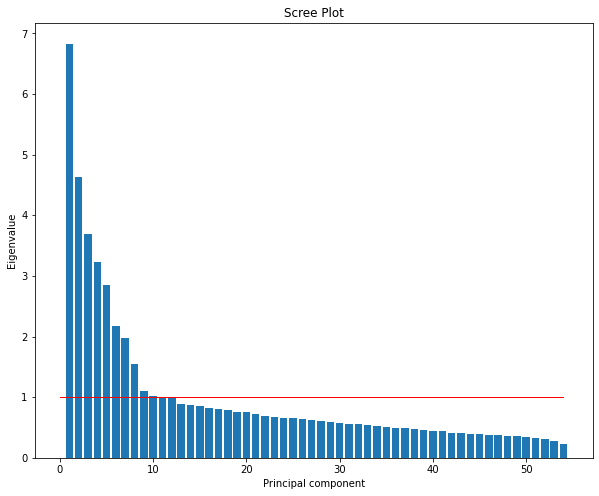

In [62]:
#%% 5 Scree plot

# It is up to us to determine how many factors we want to interpret meaningfully
# All dimension reduction methods are exhaustive, i.e. If you put 100 variables in, you
# get 100 factors back. But there are not all created equal. Some explain a
# lot more of the covariability than others. 

# Scree plot: Plotting a bar graph of the sorted Eigenvalues
numClasses = 54
plt.figure(figsize = (10,8))
plt.bar(np.linspace(1,54,54),eigVals)
plt.xlabel('Principal component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.plot([0,numClasses],[1,1],color='red',linewidth=1) # Kaiser criterion line


# There are 4 commonly used criteria to pick the number of factors that we can interpret meaningfully
    
# 1) Kaiser criterion: Keep all factors with an eigenvalue > 1
# Rationale: Each variable adds 1 to the sum of eigenvalues. The eigensum. 
# We expect each factor to explain at least as much as it adds to what needs
# to be explained. The factors have to carry their weight.
# By this criterion, we would report 2 meaningful factors. Generally speaking, this is
# a liberal criterion. You will end up with many factors, using this
# criterion. If you put in 256 EEG channels, 10 factors might exceed this
# threshold. 

# 2) The "elbow" criterion: Pick only factors left of the biggest/sharpest
# drop. This would yield 1 factor

# 3) Number of factors that account for 90% of the variance (Eigenvalues that 
# add up to 90% of the Eigensum. To account for 90% of the variability in this 
# data, we need 3 factors

# 4) "Horn's method". Simulate noise distributions to see which factors exceed
# what you would expect from noise. Resampling/Bootstrap-based. This is 
# explained in the NDS book, in the PCA chapter. 

#### According to the Kaiser Criteria we will choose 11 principal components

In [65]:
pca = decomposition.PCA(n_components=11)
pca.fit(data)
scores = pca.transform(data)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


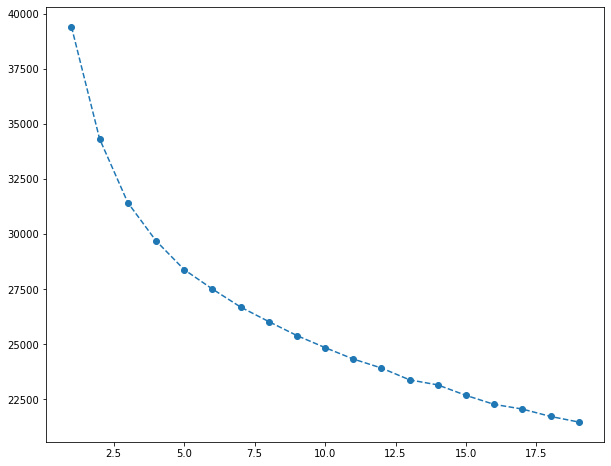

In [66]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
wcss = []
for i in range(1,20):
    k_means_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 40)
    k_means_pca.fit(scores)
    wcss.append(k_means_pca.inertia_)

plt.figure(figsize = (10,8))
plt.plot(range(1,20), wcss, marker = 'o', linestyle = '--')

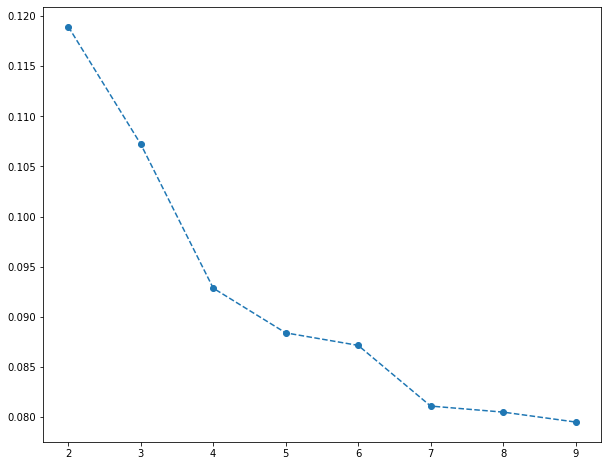

In [67]:
k_silhouette = []
#check for to 2 up to 10 clusters
for i in range(2,10):
    k_means_pca = KMeans(n_clusters = i, init = 'k-means++', random_state=0)
    k_means_pca.fit(scores)
    sil_score = silhouette_score(scores, k_means_pca.labels_)
    k_silhouette.append(sil_score)
plt.figure(figsize = (10,8))
plt.plot(range(2,10), k_silhouette, marker = 'o', linestyle = '--')

In [70]:
k_means_pca = KMeans(n_clusters = 2, init = 'k-means++', random_state = 40)
k_means_pca.fit(scores)

df_pca_kmeans = pd.concat([data.reset_index(drop = True), pd.DataFrame(scores)], axis = 1)

df_pca_kmeans.columns.values[-11:] = ['Component1', 'Component2','Component3', 'Component4',
                                    'Component5', 'Component6','Component7', 'Component8','Component9','Component10','Component11']
df_pca_kmeans['Labels'] = k_means_pca.labels_

df_pca_kmeans['Segment'] = df_pca_kmeans['Labels'].map({0:'first', 1:'second'})

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2','PC3', 'PC4','PC5', 'PC6',
                                                'PC7', 'PC8','PC9', 'PC10', 'PC11'], index=data.columns)
loading_matrix.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
Is talkative,-0.547104,-0.373695,0.529688,-0.132267,-0.077713,0.308911,-0.047906,-0.055888,-0.021995,0.128954,-0.007361
Tends to find fault with others,0.312413,-0.067399,0.255157,-0.446795,-0.068202,-0.087187,-0.069888,-0.000287,-0.090326,0.181977,-0.041221
Does a thorough job,-0.315310,-0.065902,-0.177086,-0.298648,0.243860,-0.025228,-0.178917,0.018911,-0.007826,0.000440,-0.003685
Is depressed/Blue,0.677789,-0.273876,-0.159498,-0.308752,-0.069715,0.056569,0.060466,0.196155,0.001364,-0.144342,0.094943
Is original/comes up with new ideas,-0.330580,-0.179351,-0.164856,-0.177518,-0.286231,-0.068437,-0.046805,0.284221,-0.026324,-0.030732,0.100467


In [71]:
for i in range(11):
    print(loading_matrix['PC'+str(i+1)].abs().idxmax(), round(loading_matrix['PC'+str(i+1)].abs().max(),4))

Is depressed/Blue 0.6778
When watching a movie I feel like the things on the screen are happening to me 0.9184
Tends to be quiet 0.6556
Has a forgiving nature 0.4918
Tends to be disorganized 0.6745
When watching a movie I feel like the things on the screen are happening to me 0.4857
I have trouble remembering the story of a movie a couple of days after seeing it 0.4082
Has few artistic interests 0.5266
When watching a movie I cheer or shout or talk or curse at the screen 1.0993
When watching movies things get so intense that I have to stop watching 0.7379
I have cried during a movie 0.5261


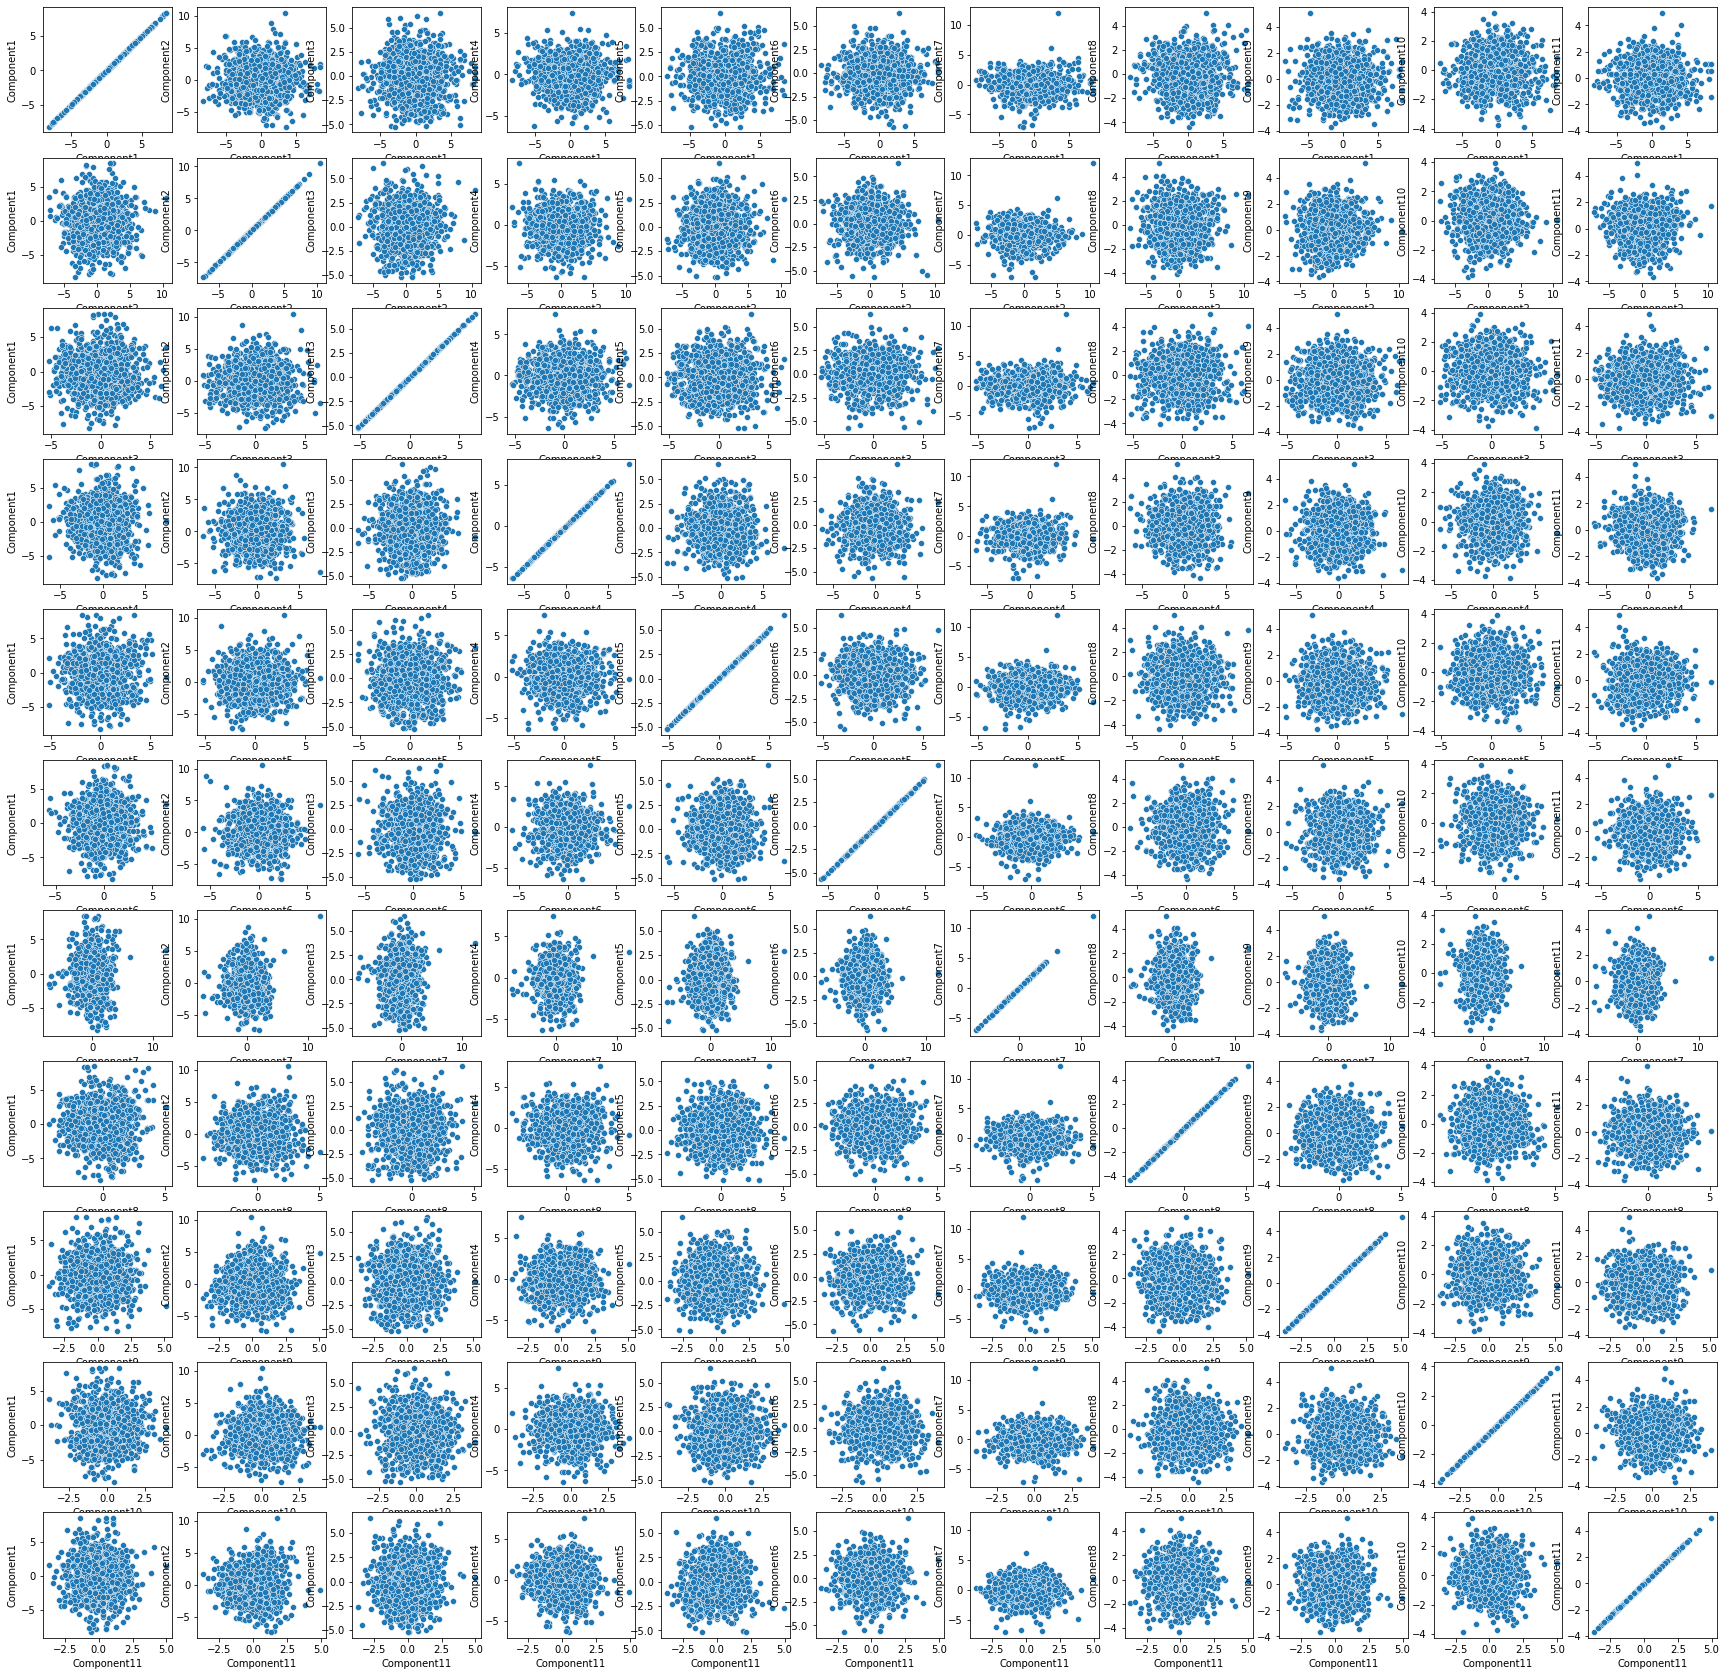

In [73]:
import warnings
warnings.filterwarnings("ignore")
fig, ax =plt.subplots(11,11, figsize = (30,30))

for i in range(11):
    for j in range(11):
        x_axis = df_pca_kmeans['Component'+str(i+1)]
        y_axis = df_pca_kmeans['Component'+str(j+1)]
        sns.scatterplot(x_axis, y_axis, ax=ax[i][j])#,'c','m'])
fig.savefig('pca.png')

<AxesSubplot:xlabel='Component1', ylabel='Component2'>

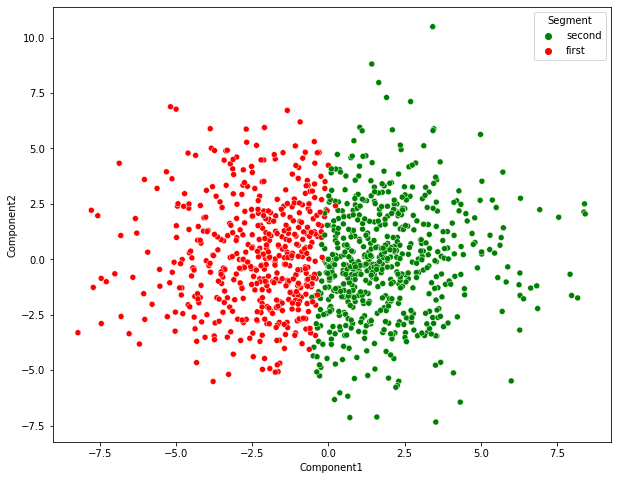

In [74]:
# 1, 2
x_axis = df_pca_kmeans['Component1']
y_axis = df_pca_kmeans['Component2']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis, y_axis, hue = df_pca_kmeans['Segment'], palette = ['g','r'])#,'c','m'])

In [75]:
X = df_pca_kmeans.iloc[:,-11:-2]
X.head()

,Component3,Component4,Component5,Component6,Component7,Component8,Component9,Component10,Component11
0,-2.575036,-0.319793,-2.868972,-5.703641,0.379202,-0.126410,-2.769604,-1.199689,-2.041372
1,-2.679736,1.050696,-1.187990,-0.991301,0.354419,-1.936549,1.392518,1.502947,-3.691766
2,0.235135,1.677181,-0.367491,-0.021292,0.941251,-0.933495,1.827604,0.940616,0.942330
3,-2.129981,-1.906576,-0.750050,4.122593,1.591382,1.246834,1.479937,0.697147,-0.551763
4,1.461603,0.513060,-0.223012,0.892313,0.615580,-0.818153,-1.171597,1.205809,0.223254


In [76]:
full_data.head()

,The Life of David Gale (2003),Wing Commander (1999),Django Unchained (2012),Alien (1979),Indiana Jones and the Last Crusade (1989),Snatch (2000),Rambo: First Blood Part II (1985),Fargo (1996),Let the Right One In (2008),Black Swan (2010),...,When watching a movie I cheer or shout or talk or curse at the screen,When watching a movie I feel like the things on the screen are happening to me,As a movie unfolds I start to have problems keeping track of events that happened earlier,"The emotions on the screen ""rub off"" on me - for instance if something sad is happening I get sad or if something frightening is happening I get scared",When watching a movie I get completely immersed in the alternative reality of the film,Movies change my position on social economic or political issues,When watching movies things get so intense that I have to stop watching,Gender identity (1 = female; 2 = male; 3 = self-described),Are you an only child? (1: Yes; 0: No; -1: Did not respond),Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)
0,2.151316,2.021127,4.000000,2.707612,3.000000,2.597656,2.365385,2.899606,2.49635,2.911565,...,1.0,6.0,2.0,5.0,5.0,5.0,1.0,1.0,0,1
1,2.151316,2.021127,1.500000,2.707612,2.778618,2.597656,2.365385,2.899606,2.49635,2.911565,...,3.0,1.0,1.0,6.0,5.0,3.0,2.0,1.0,0,0
2,2.151316,2.021127,3.153422,2.707612,2.778618,2.597656,2.365385,2.899606,2.49635,2.911565,...,5.0,4.0,3.0,5.0,5.0,4.0,4.0,1.0,1,0
3,2.151316,2.021127,2.000000,2.707612,3.000000,2.597656,2.365385,2.899606,2.49635,4.000000,...,3.0,1.0,1.0,4.0,5.0,3.0,1.0,1.0,0,1
4,2.151316,2.021127,3.500000,2.707612,0.500000,2.597656,0.500000,1.000000,2.49635,0.000000,...,2.0,3.0,2.0,5.0,6.0,4.0,4.0,1.0,1,1


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

In [78]:
roc_auc0 = []
roc_auc1 = []
roc_auc2 = []
roc_auc3 = []
roc_auc4 = []

for i in range(400):
    y = full_data.iloc[:,i:i+1]
    y = y.apply(np.floor)
    y = label_binarize(y, classes=[0, 1, 2,3,4])
    n_classes = y.shape[1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

    classifier = DecisionTreeClassifier()

    y_score = classifier.fit(X_train, y_train).predict(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    roc_auc0.append(roc_auc[0])
    roc_auc1.append(roc_auc[1])
    roc_auc2.append(roc_auc[2])
    roc_auc3.append(roc_auc[3])
    roc_auc4.append(roc_auc[4])    
    
print("ROC 0 average : ",np.nanmean(roc_auc0))
print("ROC 1 average : ",np.nanmean(roc_auc1))
print("ROC 2 average : ",np.nanmean(roc_auc2))
print("ROC 3 average : ",np.nanmean(roc_auc3))
print("ROC 4 average : ",np.nanmean(roc_auc4))

ROC 0 average :  0.4994745347634811
ROC 1 average :  0.5027971102046629
ROC 2 average :  0.5065007899746913
ROC 3 average :  0.5021065145778693
ROC 4 average :  0.5048646984145282


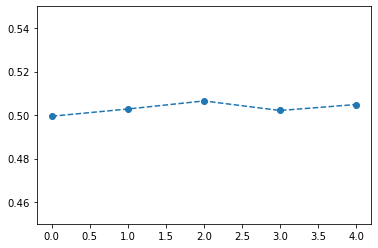

In [79]:
x = [np.nanmean(roc_auc0),np.nanmean(roc_auc1),np.nanmean(roc_auc2),np.nanmean(roc_auc3),np.nanmean(roc_auc4)]

plt.ylim([0.45, 0.55])
plt.plot(x,marker = 'o', linestyle = '--')


## Neural network model of your choice to predict movie ratings, using information from all 477 columns. 

In [91]:
from keras.models import Sequential
from keras.layers import Dense

In [94]:
X = full_data.iloc[:,420:474]
listed_accuracy = []
for i in range(400):
    y = full_data.iloc[:,i:i+1]
    y = y.apply(np.floor)
    y = label_binarize(y, classes=[0, 1, 2,3,4])
    model = Sequential()
    model.add(Dense(12, input_dim=54, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(5, activation='sigmoid'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X, y, epochs=10, batch_size=10)

    _, accuracy = model.evaluate(X, y)
    listed_accuracy.append(accuracy)

Epoch 1/10
110/110 [==============================] - 0s 2ms/step - loss: 1.8849 - accuracy: 0.0082
Epoch 2/10
110/110 [==============================] - 0s 2ms/step - loss: 1.2800 - accuracy: 0.0109
Epoch 3/10
110/110 [==============================] - 0s 2ms/step - loss: 1.2513 - accuracy: 0.0109
Epoch 4/10
110/110 [==============================] - 0s 2ms/step - loss: 1.2469 - accuracy: 0.0109
Epoch 5/10
110/110 [==============================] - 0s 2ms/step - loss: 1.1720 - accuracy: 0.0109
Epoch 6/10
110/110 [==============================] - 0s 2ms/step - loss: 0.8831 - accuracy: 0.3282
Epoch 7/10
110/110 [==============================] - 0s 2ms/step - loss: 0.3019 - accuracy: 0.9471
Epoch 8/10
110/110 [==============================] - 0s 2ms/step - loss: 0.2848 - accuracy: 0.9471
Epoch 9/10
110/110 [==============================] - 0s 2ms/step - loss: 0.2759 - accuracy: 0.9471
Epoch 10/10
35/35 [==============================] - 0s 1ms/step - loss: 0.2682 - accuracy: 0.9471
E

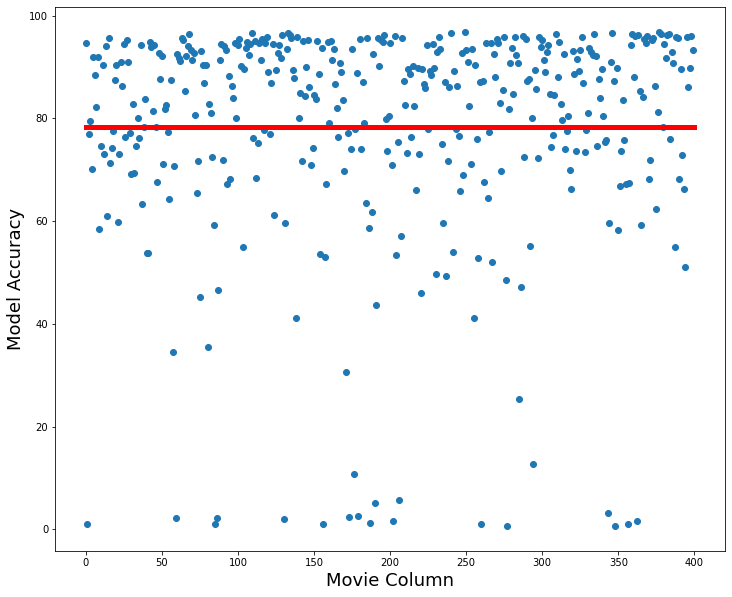

In [95]:
listed_accuracy = [x*100 for x in listed_accuracy]

plt.figure(figsize=(12,10))
x = np.arange(0,400)
plt.scatter(x,listed_accuracy,marker = 'o')
plt.xlabel("Movie Column",fontsize=18)
plt.ylabel("Model Accuracy",fontsize=18)
plt.plot([0,400],[np.nanmean(listed_accuracy),np.nanmean(listed_accuracy)],color='red',linewidth=5)

In [96]:
np.nanmean(listed_accuracy)

78.21080221037846